In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# %load ../../loaders/imports.py
import sys, os
import numpy as np
import matplotlib.pyplot as plt
import time
import pdb

# Add the uoicorr directory to the path
sys.path.append('../../../uoicorr_run')

# Add the root directory of this repository
sys.path.append('../..')

from postprocess_utils import *
import pandas as pd
import sqlalchemy

In [3]:
from job_utils.idxpckl import Indexed_Pickle

In [4]:
root_dir = '/mnt/sdb1'

In [5]:
lasso = pd.read_pickle('%s/finalfinal/lasso_concat_df.dat' % root_dir)
mcp = pd.read_pickle('%s/finalfinal/mcp_concat_df.dat' % root_dir)
scad = pd.read_pickle('%s/finalfinal/scad_concat_df.dat' % root_dir)
en = pd.read_pickle('%s/finalfinal/en_concat_df.dat' % root_dir)
uoi = pd.read_pickle('%s/finalfinal/uoi_concat_df.dat' % root_dir)

In [9]:
# Remove the parasitic index field
uoi = uoi.drop('index', axis=1)
lasso = lasso.drop('index', axis=1)
mcp = mcp.drop('index', axis=1)
scad = scad.drop('index', axis=1)
en = en.drop('index', axis=1)

# Replace with a robust index
uoi.set_index(np.arange(uoi.shape[0]), inplace=True)
lasso.set_index(np.arange(lasso.shape[0]), inplace=True)
mcp.set_index(np.arange(mcp.shape[0]), inplace=True)
scad.set_index(np.arange(scad.shape[0]), inplace=True)
en.set_index(np.arange(en.shape[0]), inplace=True)

In [19]:
# Load precalculated ss and eigenvalue bounds
with open('eigenvalue_bounds_kappa.dat', 'rb') as f:
    eigenvalue_bounds = pickle.load(f)
    ss = pickle.load(f)

In [6]:
from plotting_utils import *

In [7]:
from utils import gen_data, gen_covariance, sparsify_beta, gen_beta2

In [8]:
# Recalculate the alpha_df for the ideal case
import pickle

In [10]:
sparsity = np.unique(uoi['sparsity'].values)

In [11]:
from expanded_ensemble import load_covariance

### Calculations

In [12]:
# Pre-sparsifty the beta for inverse exponential distribution and save away, as this is a time sink
sparse_beta = []
cov_idxs = np.arange(120)
for k, s in enumerate(sparsity):            
    for cov_idx in cov_idxs:
        _, cov_param = load_covariance(cov_idx)
        # take the minimum non-zero beta value
        beta = gen_beta2(500, 500, 
                         1, -1, seed=1234, distribution='normal')        
        # Sparsify beta
        beta = sparsify_beta(beta, cov_param['block_size'], s,
                             seed = cov_param['block_size'])
        sparse_beta.append({'sparsity': s, 'cov_idx': cov_idx, 'beta': beta})

In [13]:
cov_params = [] 
for cov_idx in np.arange(120):
    _, cp = load_covariance(cov_idx)
    cov_params.append(cp)

In [14]:
sparse_beta = pd.DataFrame(sparse_beta)

In [17]:
# Eigenvalue constant
def calc_alpha_sa(cov_indices, df, rho, ss_, flag, threshold=1):
    t0 = time.time()
    alphas = np.zeros(len(cov_indices))    
    sa = np.zeros((len(cov_indices)))
    FNR = np.zeros((len(cov_indices)))
    FPR = np.zeros((len(cov_indices)))
    for i, cov_idx in enumerate(cov_indices):
        df_ = apply_df_filters(df, cov_idx=cov_idx)        
        cov_param = cov_params[cov_idx]

        # Use pregenerated beta for inverse exp due to slow time for rejection sampling
        if df_.iloc[0]['betawidth'] == -1:
            sb = apply_df_filters(sparse_beta, cov_idx=cov_idx, sparsity=df.iloc[0]['sparsity'])
            beta = sb.iloc[0]['beta']
        else:
            # take the minimum non-zero beta value
            beta = gen_beta2(df_.iloc[0]['n_features'], df_.iloc[0]['n_features'], 1, df_.iloc[0]['betawidth'], seed=1234, distribution='normal')                
            # Sparsify beta
            beta = sparsify_beta(beta[np.newaxis, :], cov_param['block_size'], df_.iloc[0]['sparsity'], seed = cov_param['block_size'])

        beta=beta.ravel()

        alphas[i] = np.mean(rho[i] * np.min(np.abs(beta[np.nonzero(beta)[0]])**2)/ss_[i])

        # Just return the average selection accuracy
        if flag is None:
            sa[i] = np.mean(df_['sa'].values)
            FNR[i] = np.mean(df_['FNR'].values)
            FPR[i] = np.mean(df_['FPR'].values)            
        if flag == 'threshold':
            sa[i] = np.count_nonzero(1 * df_.iloc[cov_indices[i]]['sa'].values > threshold)/len(cov_indices[i])
           
    return alphas, sa, FNR, FPR

In [18]:
np_ratios = np.unique(uoi['np_ratio'].values)
kappa = np.unique(uoi['kappa'].values)

In [21]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
betawidth = np.unique(lasso['betawidth'].values)
selection_methods = np.unique(lasso['selection_method'])
dframes = [uoi, lasso, mcp, scad, en]
dframe_names = ['UoI Lasso', 'Lasso', 'MCP', 'SCAD', 'EN']
# Need to create a dataframe 
alpha_datalist_uoi = []

# Handle the ideal case first
kappa = 10
np_ratio = 16

for i, dframe in enumerate(dframes):                
    for j, bw in enumerate(betawidth):
        t0 = time.time() 
        for h, sm in enumerate(selection_methods):
            for k, s in enumerate(sparsity):            
                df = apply_df_filters(dframe, kappa=kappa, np_ratio=np_ratio, selection_method=sm,
                                      betawidth=bw, sparsity=s)
                cov_indices = np.unique(df['cov_idx'].values) 
                alpha_, sa_, FNR_, FPR_ = calc_alpha_sa(cov_indices, df, rho=eigenvalue_bounds[:, k],
                                            ss_=ss[:, k, j, -1], flag=None) 
                alpha_datalist_uoi.append({'df_name' : dframe_names[i], 'betawidth': bw, 'sparsity' : s,
                                       'alpha': alpha_, 'sa': sa_, 'selection_method': sm,
                                        'kappa': kappa, 'np_ratio': np_ratio, 'cov_indices': cov_indices,
                                        'FPR': FPR_, 'FNR': FNR_})       
        print('Dataframe: %s, bw_idx: %d, time: %f' % (dframe_names[i], j, time.time() - t0))

Dataframe: UoI Lasso, bw_idx: 0, time: 46.346169
Dataframe: UoI Lasso, bw_idx: 1, time: 42.595206
Dataframe: UoI Lasso, bw_idx: 2, time: 41.690410
Dataframe: Lasso, bw_idx: 0, time: 62.390750
Dataframe: Lasso, bw_idx: 1, time: 64.135332
Dataframe: Lasso, bw_idx: 2, time: 61.043689
Dataframe: MCP, bw_idx: 0, time: 62.752235
Dataframe: MCP, bw_idx: 1, time: 58.825771
Dataframe: MCP, bw_idx: 2, time: 59.658640
Dataframe: SCAD, bw_idx: 0, time: 61.483234
Dataframe: SCAD, bw_idx: 1, time: 61.520921
Dataframe: SCAD, bw_idx: 2, time: 60.391389
Dataframe: EN, bw_idx: 0, time: 60.468528
Dataframe: EN, bw_idx: 1, time: 62.241987
Dataframe: EN, bw_idx: 2, time: 64.909927


In [24]:
alpha_datalist = pd.DataFrame(alpha_datalist_uoi)

In [25]:
with open('alpha_fnrfpr_case3.dat', 'wb') as f:
    f.write(pickle.dumps(alpha_datalist))

In [35]:
len(alpha_datalist_uoi)

3600

In [34]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
betawidth = np.unique(lasso['betawidth'].values)
selection_methods = np.unique(lasso['selection_method'])
dframes = [uoi, lasso, mcp, scad, en]
dframe_names = ['UoI Lasso', 'Lasso', 'MCP', 'SCAD', 'EN']
# Need to create a dataframe 
alpha_datalist_case1 = []

# Case 1
kappa = 1
np_ratio = 4

for i, dframe in enumerate(dframes):                
    for j, bw in enumerate(betawidth):
        t0 = time.time() 
        for h, sm in enumerate(selection_methods):
            for k, s in enumerate(sparsity):            
                df = apply_df_filters(dframe, kappa=kappa, np_ratio=np_ratio, selection_method=sm,
                                      betawidth=bw, sparsity=s)
                cov_indices = np.unique(df['cov_idx'].values) 
                alpha_, sa_, FNR_, FPR_ = calc_alpha_sa(cov_indices, df, rho=eigenvalue_bounds[:, k],
                                            ss_=ss[:, k, j, 0], flag=None) 
                alpha_datalist_case1.append({'df_name' : dframe_names[i], 'betawidth': bw, 'sparsity' : s,
                                       'alpha': alpha_, 'sa': sa_, 'selection_method': sm,
                                        'kappa': kappa, 'np_ratio': np_ratio, 'cov_indices': cov_indices,
                                        'FPR': FPR_, 'FNR': FNR_})       
        print('Dataframe: %s, bw_idx: %d, time: %f' % (dframe_names[i], j, time.time() - t0))

Dataframe: UoI Lasso, bw_idx: 0, time: 45.842986
Dataframe: UoI Lasso, bw_idx: 1, time: 43.445526
Dataframe: UoI Lasso, bw_idx: 2, time: 42.762576
Dataframe: Lasso, bw_idx: 0, time: 62.253847
Dataframe: Lasso, bw_idx: 1, time: 64.695160
Dataframe: Lasso, bw_idx: 2, time: 61.761430
Dataframe: MCP, bw_idx: 0, time: 63.361611
Dataframe: MCP, bw_idx: 1, time: 66.991327
Dataframe: MCP, bw_idx: 2, time: 64.733116
Dataframe: SCAD, bw_idx: 0, time: 65.722988
Dataframe: SCAD, bw_idx: 1, time: 64.216165
Dataframe: SCAD, bw_idx: 2, time: 64.763794
Dataframe: EN, bw_idx: 0, time: 60.128032
Dataframe: EN, bw_idx: 1, time: 59.704436
Dataframe: EN, bw_idx: 2, time: 58.515568


In [37]:
# Dumbass
alpha_datalist_case1 = pd.DataFrame(alpha_datalist_uoi)
alpha_datalist_case1 = apply_df_filters(alpha_datalist_case1, kappa=1, np_ratio=4)

In [39]:
# Plot either the average selection accuracy or the percent of runs that exceed a certain threshold as a 
# function of the parameter alpha. alpha = rho(Omega) sum(beta_min^2)/sigma^2

# Calculate across signal to noise ratios, n/p ratio = 4
betawidth = np.unique(lasso['betawidth'].values)
selection_methods = np.unique(lasso['selection_method'])
dframes = [uoi, lasso, mcp, scad, en]
dframe_names = ['UoI Lasso', 'Lasso', 'MCP', 'SCAD', 'EN']
# Need to create a dataframe 
alpha_datalist_case2 = []

# Case 2
kappa = 5
np_ratio = 2

for i, dframe in enumerate(dframes):                
    for j, bw in enumerate(betawidth):
        t0 = time.time() 
        for h, sm in enumerate(selection_methods):
            for k, s in enumerate(sparsity):            
                df = apply_df_filters(dframe, kappa=kappa, np_ratio=np_ratio, selection_method=sm,
                                      betawidth=bw, sparsity=s)
                cov_indices = np.unique(df['cov_idx'].values) 
                alpha_, sa_, FNR_, FPR_ = calc_alpha_sa(cov_indices, df, rho=eigenvalue_bounds[:, k],
                                            ss_=ss[:, k, j, 0], flag=None) 
                alpha_datalist_case2.append({'df_name' : dframe_names[i], 'betawidth': bw, 'sparsity' : s,
                                       'alpha': alpha_, 'sa': sa_, 'selection_method': sm,
                                        'kappa': kappa, 'np_ratio': np_ratio, 'cov_indices': cov_indices,
                                        'FPR': FPR_, 'FNR': FNR_})       
        print('Dataframe: %s, bw_idx: %d, time: %f' % (dframe_names[i], j, time.time() - t0))

Dataframe: UoI Lasso, bw_idx: 0, time: 44.535411
Dataframe: UoI Lasso, bw_idx: 1, time: 46.114095
Dataframe: UoI Lasso, bw_idx: 2, time: 43.982970
Dataframe: Lasso, bw_idx: 0, time: 61.546397
Dataframe: Lasso, bw_idx: 1, time: 62.094577
Dataframe: Lasso, bw_idx: 2, time: 63.981200
Dataframe: MCP, bw_idx: 0, time: 66.674311
Dataframe: MCP, bw_idx: 1, time: 61.370337
Dataframe: MCP, bw_idx: 2, time: 60.065854
Dataframe: SCAD, bw_idx: 0, time: 61.411647
Dataframe: SCAD, bw_idx: 1, time: 62.378955
Dataframe: SCAD, bw_idx: 2, time: 63.329239
Dataframe: EN, bw_idx: 0, time: 60.979404
Dataframe: EN, bw_idx: 1, time: 64.071753
Dataframe: EN, bw_idx: 2, time: 59.477434


In [40]:
alpha_datalist_case2 = pd.DataFrame(alpha_datalist_case2)

In [41]:
with open('alpha_fnrfpr_case2.dat', 'wb') as f:
    f.write(pickle.dumps(alpha_datalist_case2))

In [42]:
with open('alpha_fnrfpr_case1.dat', 'wb') as f:
    f.write(pickle.dumps(alpha_datalist_case1))

### Plotting

In [27]:
from collections import OrderedDict

##### FPR inspection

Text(0.5, 0.98, 'BIC Selection')

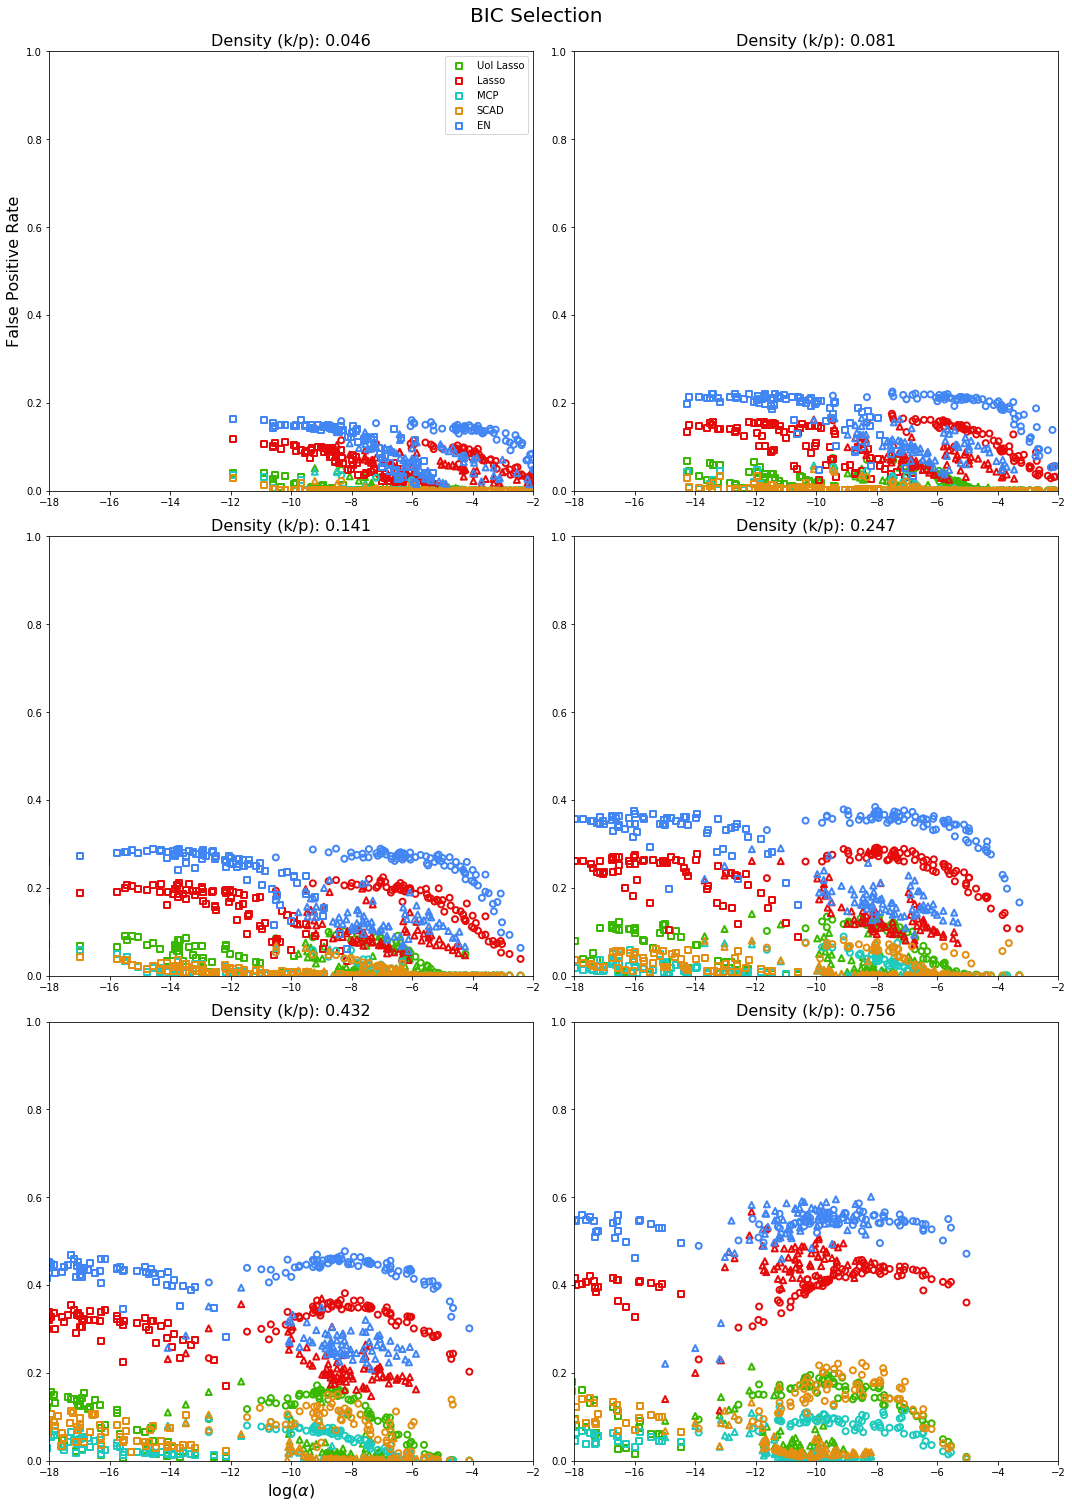

In [29]:
# For each sparsity and correlation, plot a scatter plot of the false negative rate (false positive rate)
np_ratio = 16
kappa = 10
selection_method = 'BIC'
# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['FPR'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('False Positive Rate', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('BIC Selection', fontsize=20)
# plt.savefig('BICalpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

Text(0.5, 0.98, 'BIC Selection')

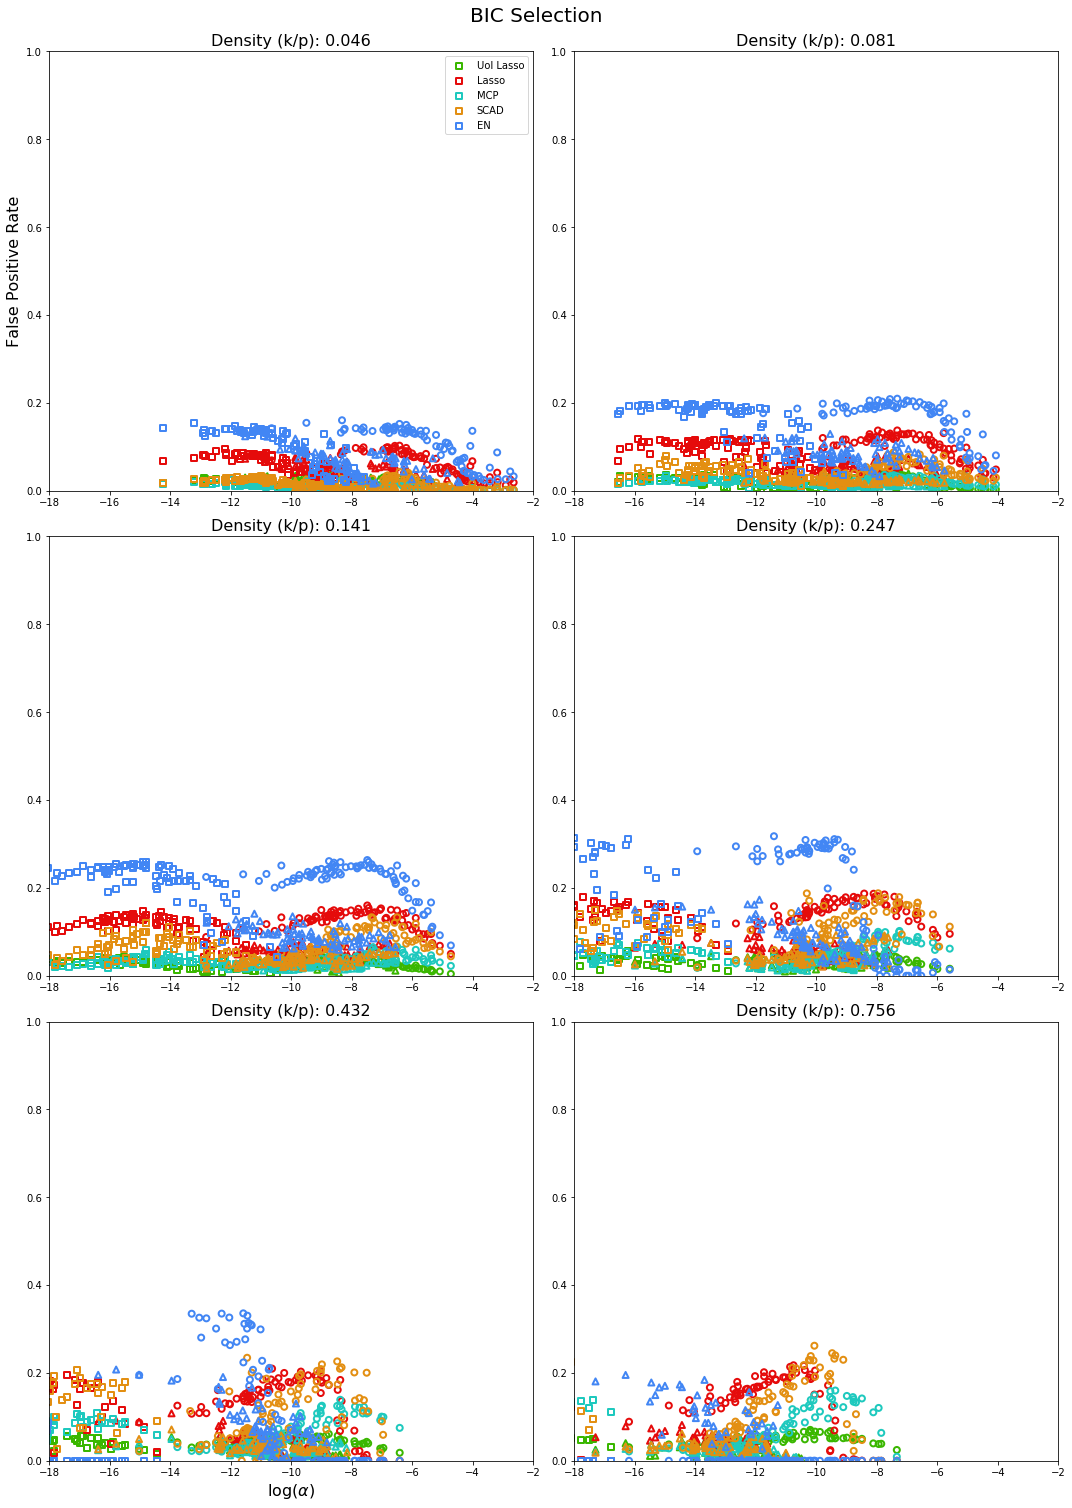

In [43]:
# For each sparsity and correlation, plot a scatter plot of the false negative rate (false positive rate)
np_ratio = 16
kappa = 10
selection_method = 'BIC'
# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist_case1, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['FPR'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('False Positive Rate', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('BIC Selection', fontsize=20)
# plt.savefig('BICalpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

#### FNR case 3

Text(0.5, 0.98, 'BIC Selection')

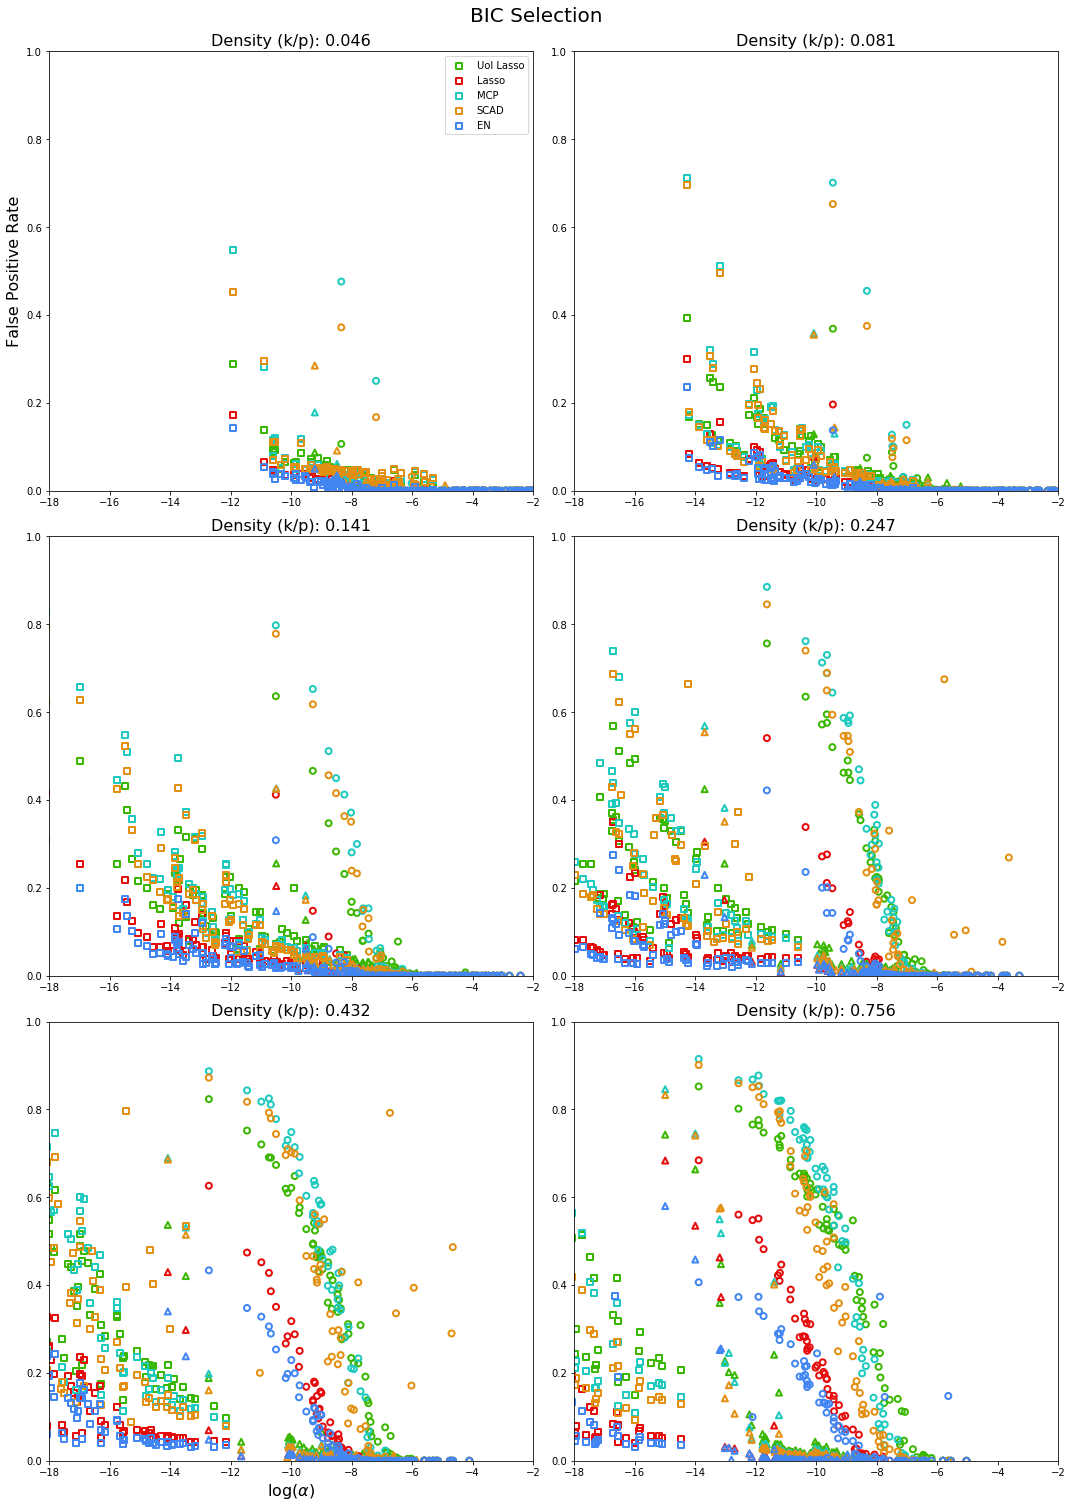

In [30]:
# For each sparsity and correlation, plot a scatter plot of the false negative rate (false positive rate)
np_ratio = 16
kappa = 10
selection_method = 'BIC'
# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['FNR'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('False Positive Rate', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('BIC Selection', fontsize=20)
# plt.savefig('BICalpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

Text(0.5, 0.98, 'BIC Selection')

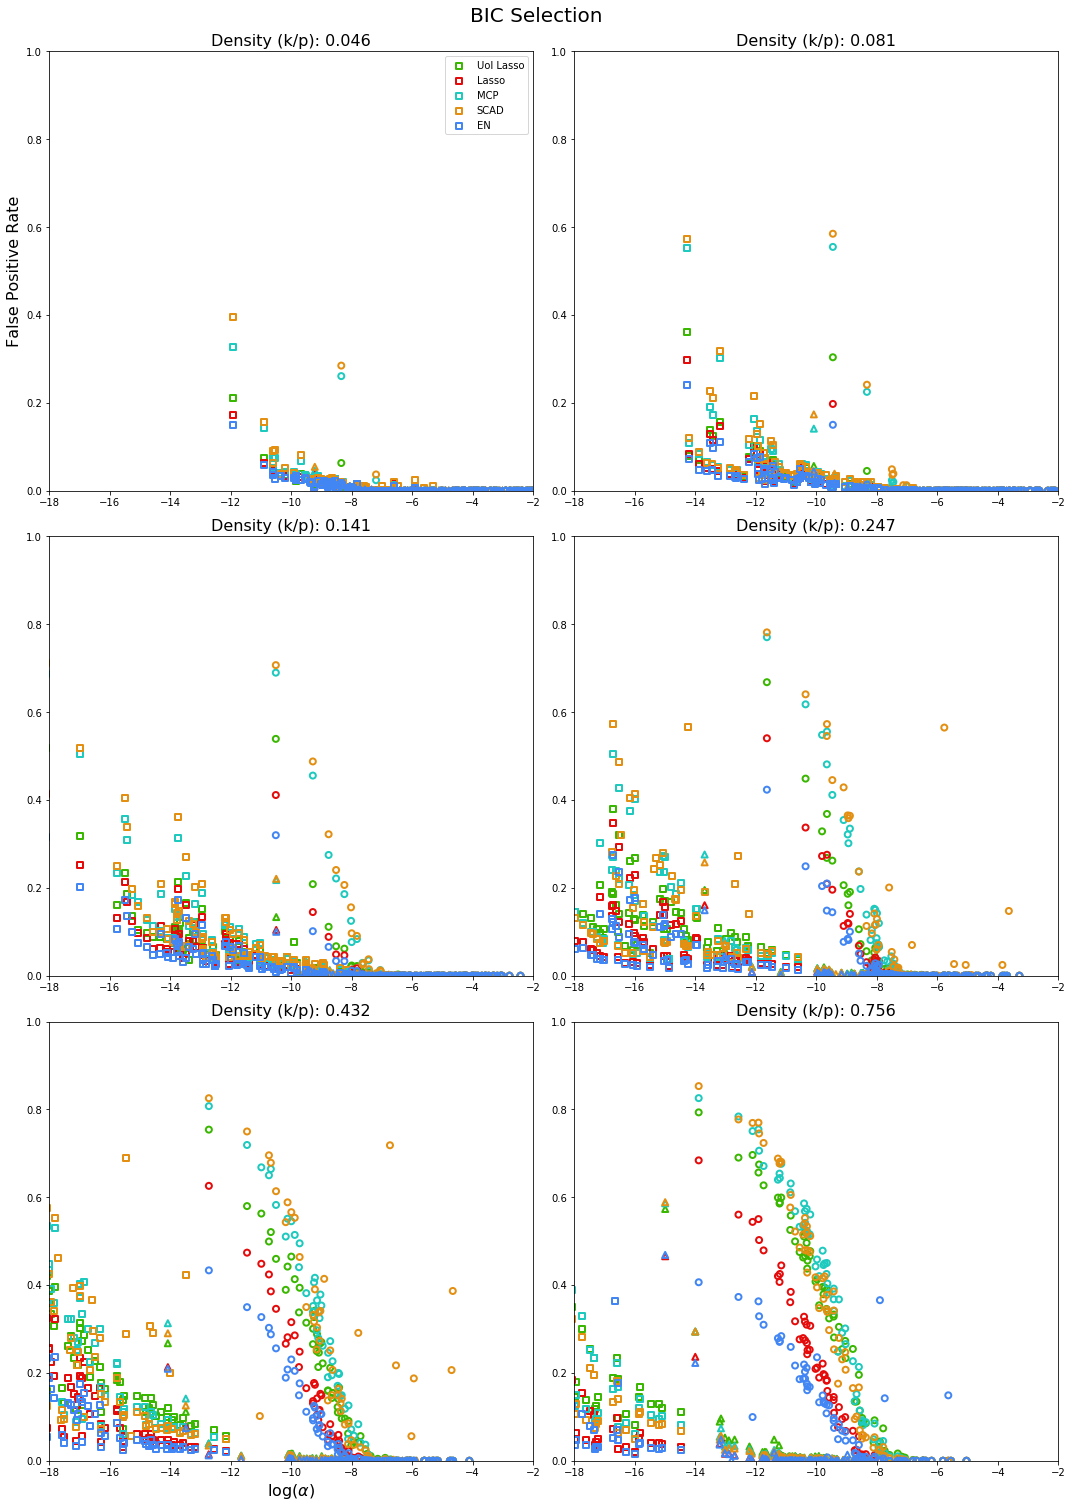

In [31]:
# For each sparsity and correlation, plot a scatter plot of the false negative rate (false positive rate)
np_ratio = 16
kappa = 10
selection_method = 'AIC'
# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['FNR'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('False Positive Rate', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('BIC Selection', fontsize=20)
# plt.savefig('BICalpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

Text(0.5, 0.98, 'BIC Selection')

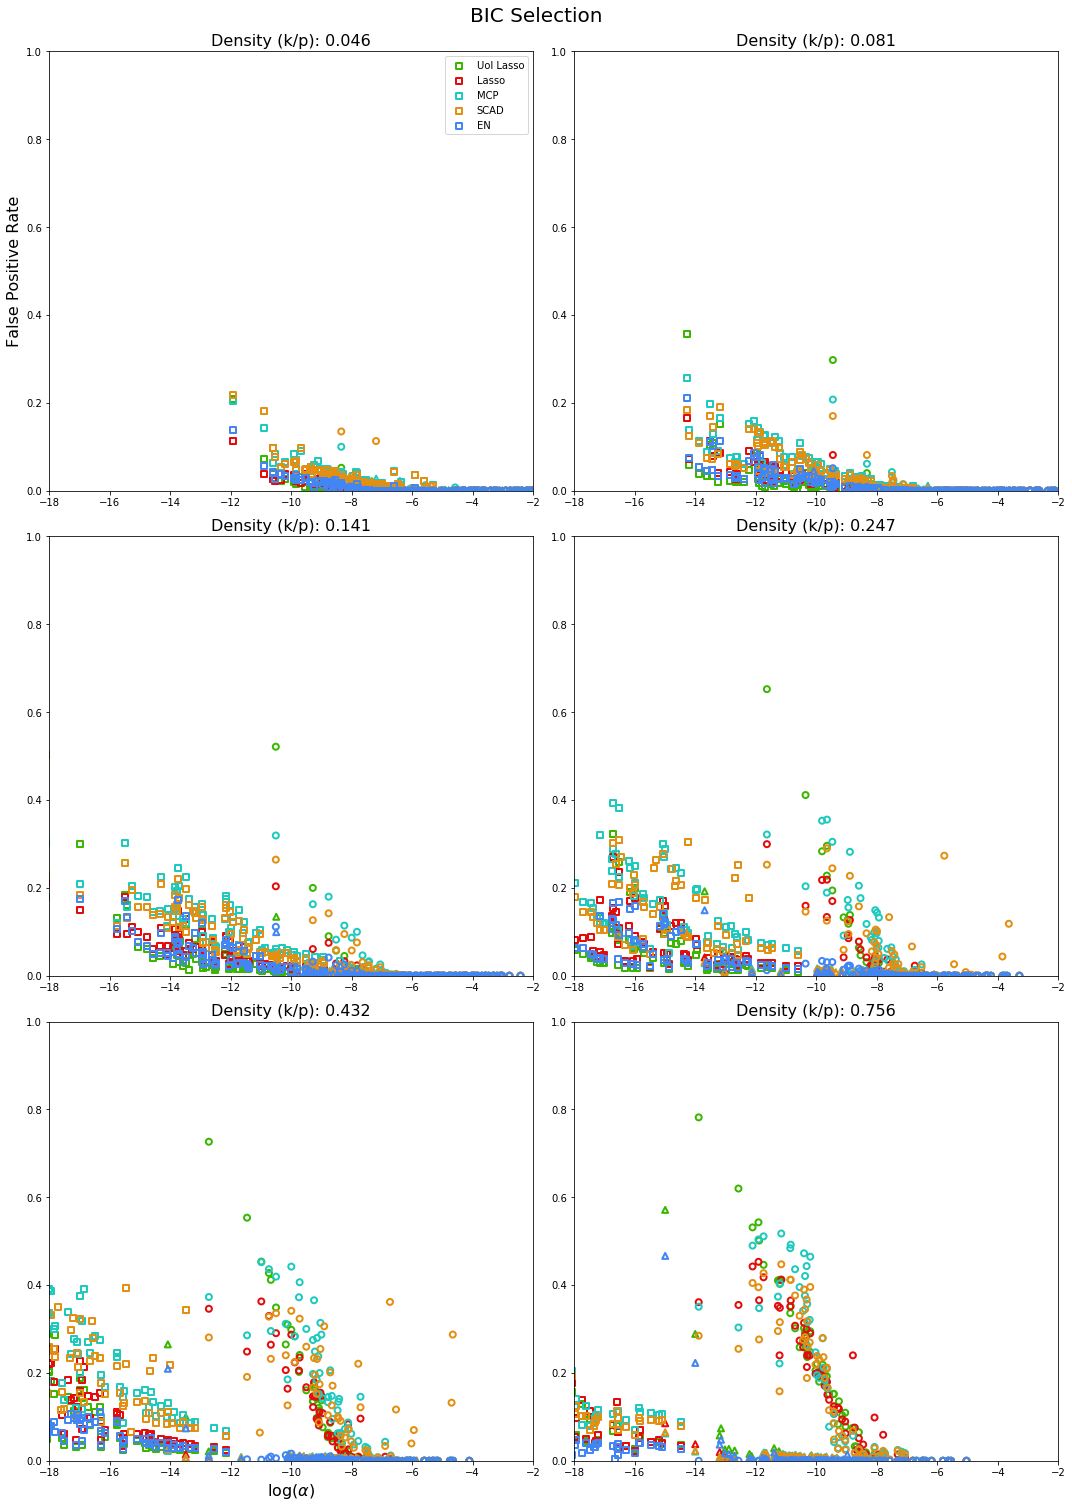

In [32]:
# For each sparsity and correlation, plot a scatter plot of the false negative rate (false positive rate)
np_ratio = 16
kappa = 10
selection_method = 'CV'
# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['FNR'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('False Positive Rate', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('BIC Selection', fontsize=20)
# plt.savefig('BICalpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

Text(0.5, 0.98, 'BIC Selection')

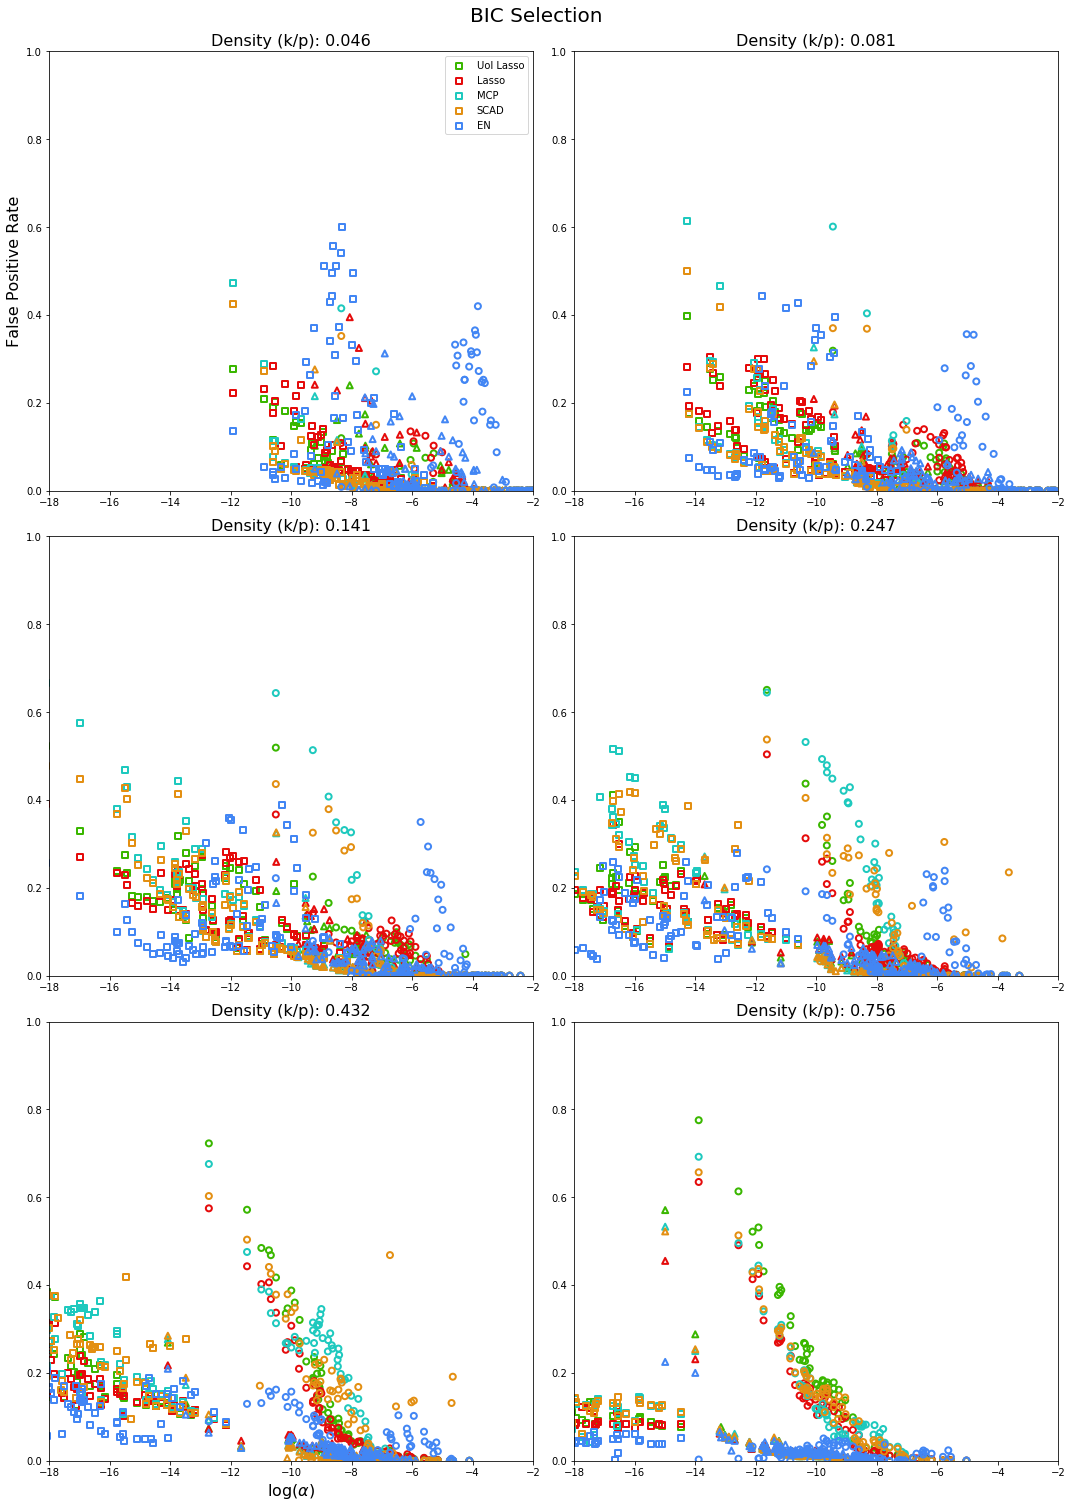

In [33]:
# For each sparsity and correlation, plot a scatter plot of the false negative rate (false positive rate)
np_ratio = 16
kappa = 10
selection_method = 'oracle'
# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['FNR'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('False Positive Rate', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('BIC Selection', fontsize=20)
# plt.savefig('BICalpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

#### FNR cases 1 and 2

Text(0.5, 0.98, 'BIC Selection')

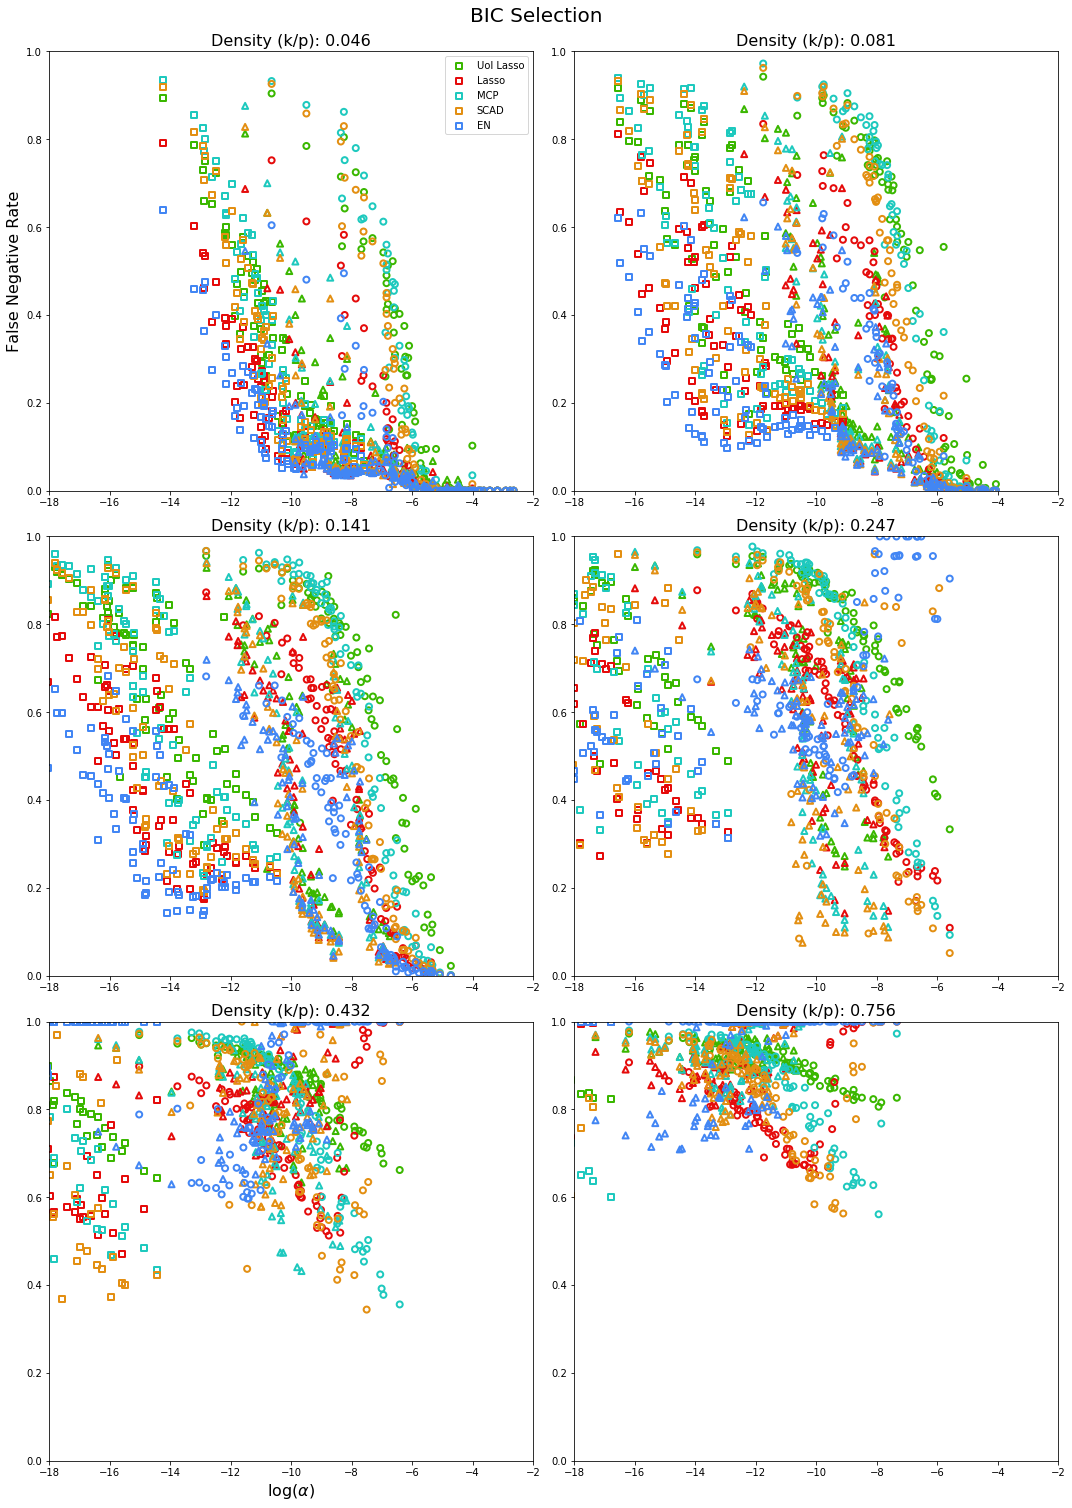

In [45]:
# For each sparsity and correlation, plot a scatter plot of the false negative rate (false positive rate)
np_ratio = 4
kappa = 1
selection_method = 'BIC'
# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist_case1, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['FNR'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('False Negative Rate', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('BIC Selection', fontsize=20)
# plt.savefig('BICalpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

Text(0.5, 0.98, 'BIC Selection')

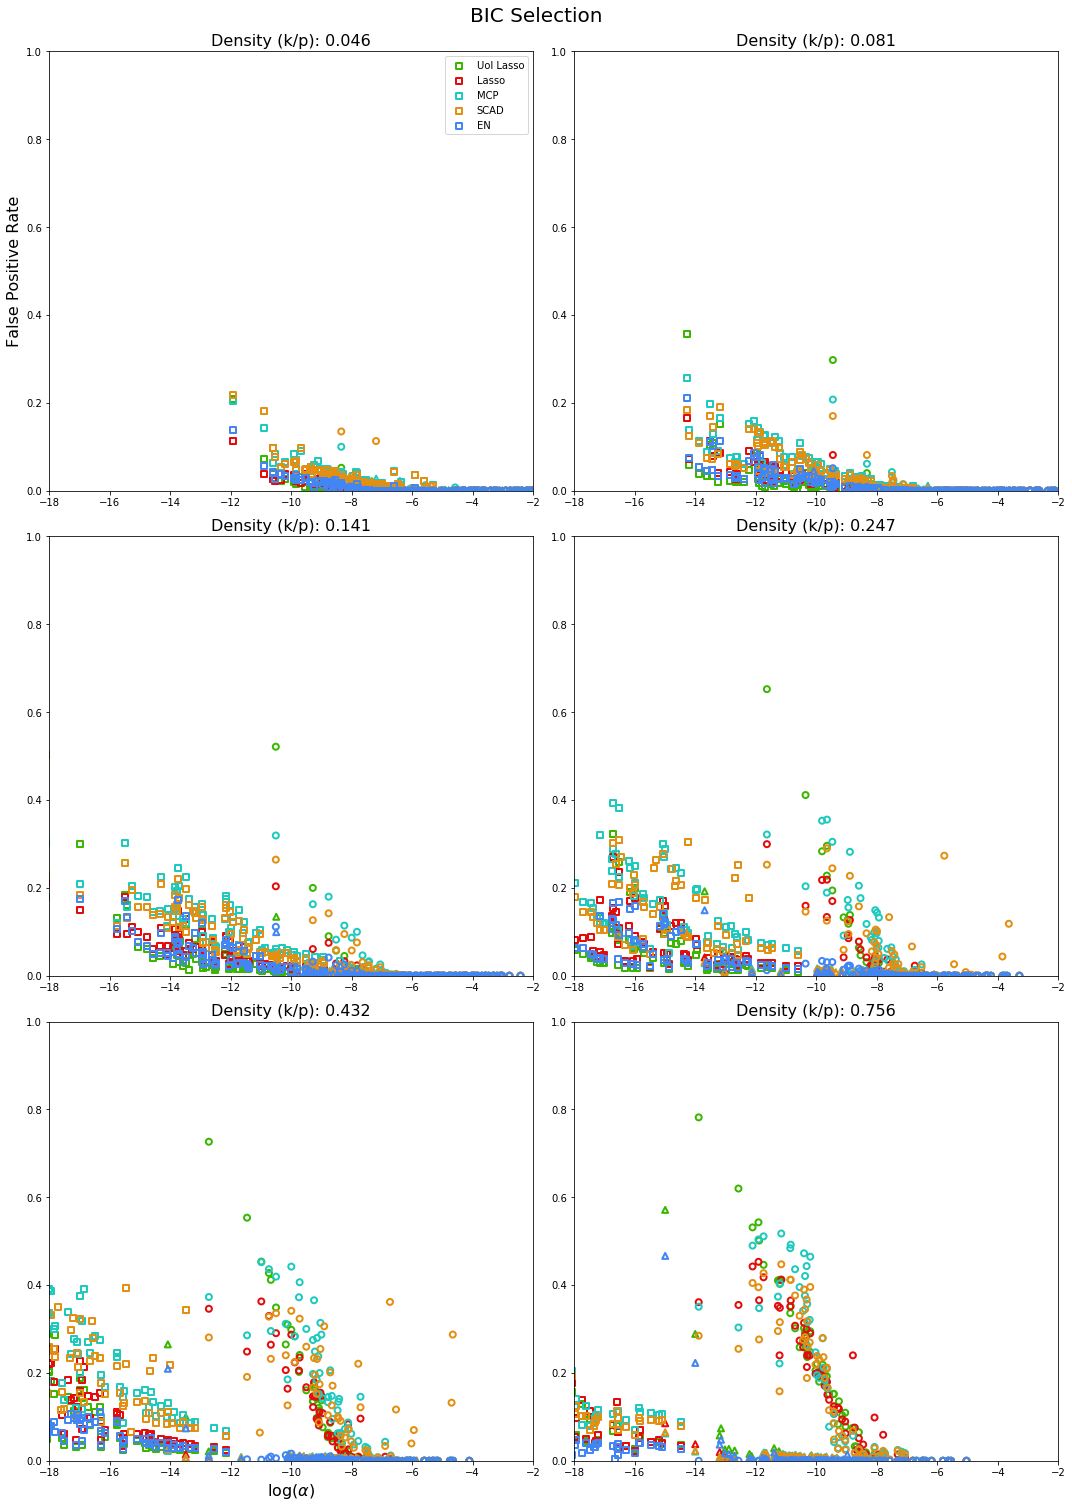

In [46]:
# For each sparsity and correlation, plot a scatter plot of the false negative rate (false positive rate)
np_ratio = 16
kappa = 10
selection_method = 'CV'
# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['FNR'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('False Positive Rate', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('BIC Selection', fontsize=20)
# plt.savefig('BICalpha_scaling.pdf', bbox_inches='tight', pad_inches=0)

Text(0.5, 0.98, 'BIC Selection')

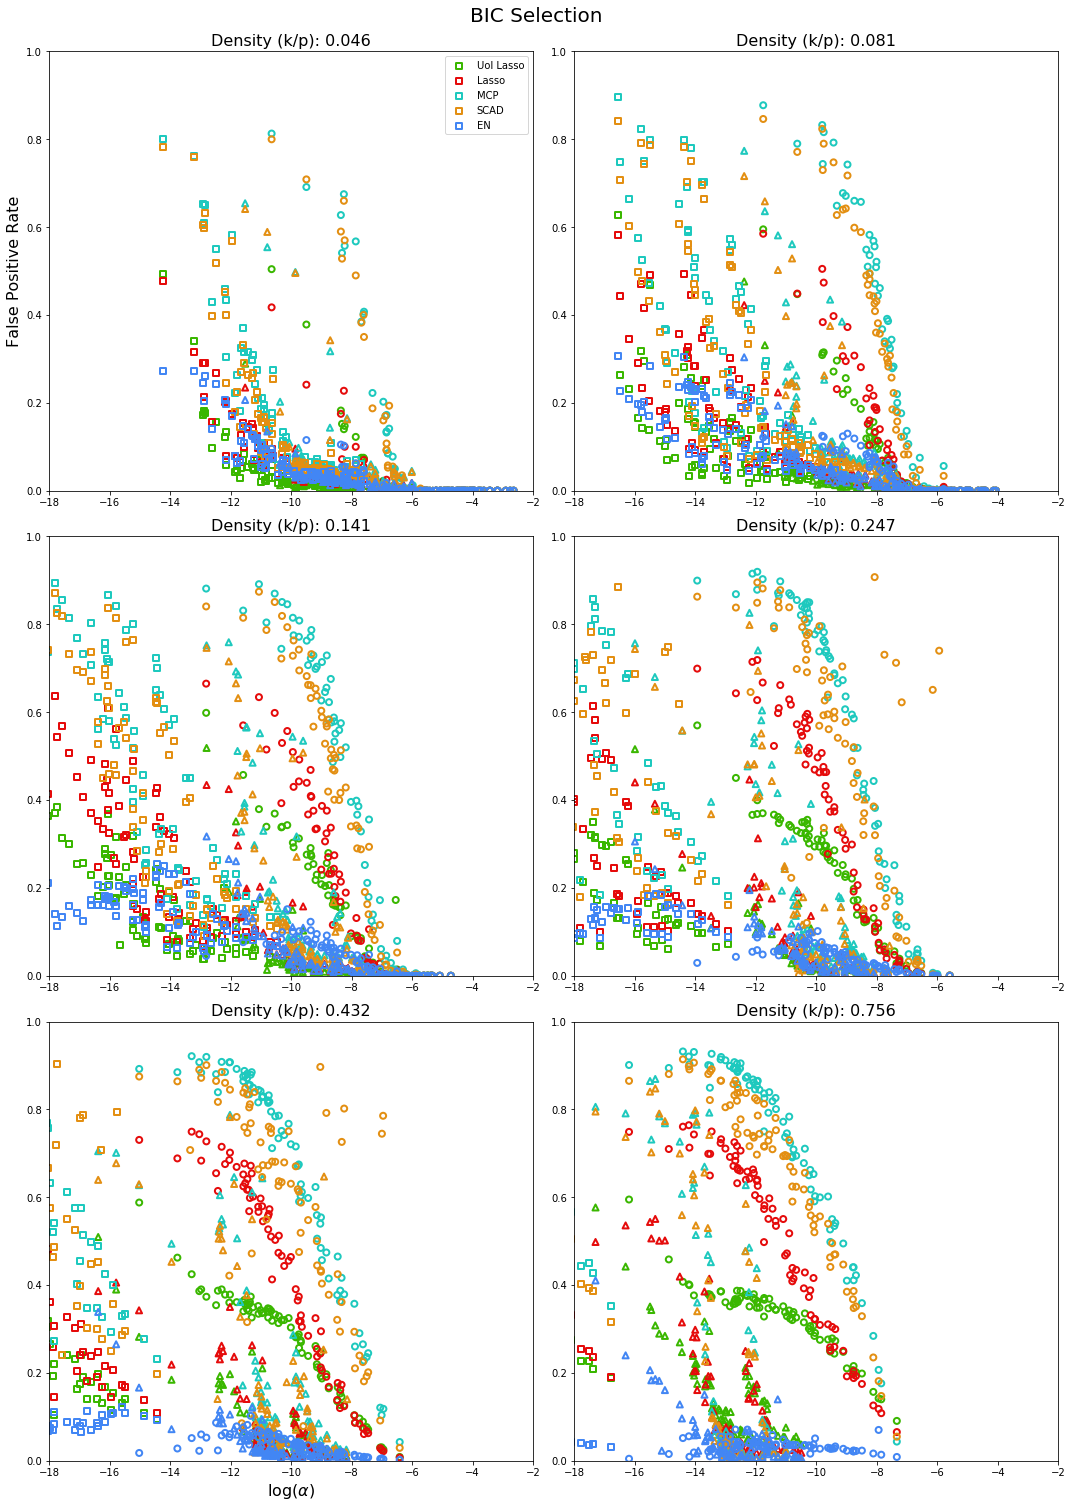

In [47]:
# For each sparsity and correlation, plot a scatter plot of the false negative rate (false positive rate)
np_ratio = 16
kappa = 10
selection_method = 'CV'
# Subsample sparsity
sparsity_ = [sparsity[3], sparsity[5], sparsity[7], sparsity[9], sparsity[11], sparsity[13]]

# Blue
c1 = ['#4286f4', '#99bdf7', '#00aeff']
# Green
c2 = ['#3ab700', '#bae288', '#64821d']
# Red
c3 = ['#e50b0b', '#ef5f5f', '#70001d']
# Cyan
c4 = ['#1ec9be', '#d799ff', '#572677']
# Orange
c5 = ['#e38f12']

# Per dframe
cols = [c2[0], c3[0], c4[0], c5[0], c1[0]]

# Per betawdith
marker_type = ['^', 'o', 's']
pal_colors = cols

# There will only be one curve over all snr, cov_params, betawidth, etc...
# np_ratio and selection methods will vary

# Create a separate subplot for each sparsity
fig, ax = plt.subplots(3, 2, figsize=(15, 22))

for h, s in enumerate(sparsity_):
    a = ax[np.unravel_index(h, (3,2))]
    for i, dframe in enumerate(dframe_names):      
        for k, bw in enumerate(betawidth):
            rows = apply_df_filters(alpha_datalist_case2, df_name=dframe, selection_method=selection_method,
                                    sparsity=s, betawidth=bw)
            for j in range(rows.shape[0]):
                 a.scatter(np.ma.log(rows.iloc[j]['alpha']), rows.iloc[j]['FNR'], label=rows.iloc[j]['df_name'],
                           edgecolor=cols[list(dframe_names).index(rows.iloc[j]['df_name'])],
                           marker=marker_type[k], facecolor="None", lw=2)    
                    
    a.set_xlim([-18, -2])
    a.set_ylim([0, 1])
    a.set_title('Density (k/p): %.3f' % s, fontsize=16)
    
ax[0, 0].set_ylabel('False Positive Rate', fontsize=16)
ax[2, 0].set_xlabel(r'$\log(\alpha)$', fontsize=16)
handles, labels = ax[0, 0].get_legend_handles_labels()
by_label = OrderedDict(zip(labels, handles))
ax[0, 0].legend(by_label.values(), by_label.keys())

fig.tight_layout(rect=[0, 0.03, 1, 0.97])
fig.suptitle('BIC Selection', fontsize=20)
# plt.savefig('BICalpha_scaling.pdf', bbox_inches='tight', pad_inches=0)